<a href="https://www.cognitiveclass.ai"><img src = "https://cognitiveclass.ai/wp-content/themes/bdu3.0/static/images/cc-logo.png" align = left></a>

<br>
<br>

--------------------
# Search for Extra Terrestrial Intelligence (SETI)
###  SETI Signal Classification on PowerAI with Multi GPU
<hr>
<br>

### Introduction
In this Notebook, we will use the famous [SETI Dataset](https://github.com/setiQuest/ML4SETI/) to build a Convolutional Neural Networks capable to perform signals classification. CNN will say, with some associated error, what type of signal is the presented input. In this notebook, you will use IBM PowerAI with multiple GPU to train the model.

### Project overview:
Each night, using the Allen Telescope Array (ATA) in northern California, the SETI Institute scans the sky at various radio frequencies, observing star systems with known exoplanets, searching for faint but persistent signals. The current signal detection system is programmed to search only for particular kinds of signals: narrow-band carrier waves. However, the detection system sometimes triggers on signals that are not narrow-band signals  (with unknown efficiency) and are also not explicitly-known radio frequency interference (RFI). There seems to be various categories of these kinds of events that have been observed in the past.

Our goal is to classify these accurately in real-time. This may allow the signal detection system to make better observational decisions, increase the efficiency of the nightly scans, and allow for explicit detection of these other signal types.

For more information refer to [SETI hackathon page](https://github.com/setiQuest/ML4SETI/).


Framing the radio signal data into spectrogram (a 2D visual representation), we can convert the problem into something akin to an image classification problem. CNN, will be run on the images which are the result of converting the signals to spectrogram.

### Training on Multi-GPU:
Today, many systems contains multiple GPUs for high performance computation. We can leverage this environments to run the training operation concurrently across multiple cards. One sample of these kind of environments is [IBM PowerAI](http://cocl.us/SETI-NIMBIX-PowerAI). In this notebook, we show you how to design and run your model on multiple GPUs.





In [1]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import time
#!sudo pip install sklearn
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from six.moves import urllib
import sys
import tarfile
import re
import math

### Set the destination folder

In [2]:
### SET YOUR WORKING SPACE HERE! Use this folder to save intermediate results.
dataset_name = 'SETI_ds_64x128'
data_dir = "tmp/SETI1_data/"
train_dir = 'tmp/SETI1_train/'
log_dir = train_dir + 'log6'
#check point directory
chk_directory = train_dir + '/save/'
checkpoint_path = chk_directory + 'model.ckpt'

if os.path.exists(data_dir) is False:
    os.makedirs(data_dir)
print data_dir


if os.path.exists(train_dir) is False:
    os.makedirs(train_dir)
print train_dir

tmp/SETI1_data/
tmp/SETI1_train/


### Import dataset reader
The signals for this notebook, have been converted to spectogram images, and stored as 4 files.
The following cell will load a python code that help us to decode the binary file, and read the SETI dataset.

In [3]:
!wget -q --output-document  SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

Archive:  SETI.zip
  inflating: SETI.py                 
  inflating: __MACOSX/._SETI.py      


### Download data
The dataset exist and shared on IBM box. Running the following cell, you can download the dataset and extract it.

In [4]:
def maybe_download_and_extract():
    DATA_URL =  'https://ibm.box.com/shared/static/qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz'
    dest_directory = data_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        print 'No zip file exist in ', imagefilepath
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)

    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    extracted_dir_path = os.path.join(dest_directory, dataset_name)
    if not os.path.exists(extracted_dir_path):
        print 'Extracting to', extracted_dir_path
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
maybe_download_and_extract()

('Successfully downloaded', 'qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz', 2432541, 'bytes.')


### Load data SETI

In [5]:
ds_directory = data_dir + dataset_name
dataset = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
num_examples = dataset.train.num_examples
print 'Number of time series:', num_examples
dataset.train.images.shape

Extracting tmp/SETI1_data/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting tmp/SETI1_data/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting tmp/SETI1_data/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting tmp/SETI1_data/SETI_ds_64x128/test-labels-idx1-ubyte.gz
Number of time series: 2000


(2000, 8192)

### Understanding the imported data

The imported data can be divided as follow:

- Training (dataset.train) >>  Use the given dataset with inputs and related outputs for training of NN. In our case, if you give an image that you know that represents a "class1", this set will tell the neural network that we expect a "class1" as the output.  
        - 2,000 signals (images)
        - dataset.train.images for inputs
        - dataset.train.labels for outputs
  
  
- Test (dataset.test) >> the model does not have access to this informations prior to the test phase. It is used to evaluate the performance and accuracy of the model against "real life situations". No further optimization beyond this point.  
        - 8,000 data points
        - dataset.test.images for inputs
        - dataset.test.labels for outputs
        
        
#### Labels
- Each image (spectrum of signal) in the dataset has been labeled from 1 to 4, representing:
    - squiggle
    - narrowband
    - noise
    - narrowbanddrd

## Network Parameters

We place the parameters on CPU.   
__Notice:__ This code is not optimal for single-GPU training due to the cost of copying parameters between CPU and GPU.

In [6]:
# Parameters
decay_rate=0.96  #decay every 1000 steps with a base of 0.96:
decay_steps=1500
learning_rate = 0.005
training_epochs = 5000
batch_size = 128
display_step = 100
moving_avg_decay = 0.9999     # The decay to use for the moving average.

#check point directory
chk_directory = train_dir +'/save/'
checkpoint_path = chk_directory + 'model.ckpt'


num_classes = 4 # number of possible classifications for the problem
dropout = 0.50 # Dropout, probability to keep units

height = 64 # height of the image in pixels 
width = 128 # width of the image in pixels 
n_input = width * height # number of pixels in one image 
num_GPUs = 4

In [7]:
def read_inputs():
    train_img_ds = dataset.train.images
    image = tf.convert_to_tensor(train_img_ds, np.float32)
    image = tf.reshape(image, [-1,height,width,1], name = 'images')
    train_lb_ds = dataset.train.labels
    label = tf.convert_to_tensor(train_lb_ds, np.float32)
    #label = tf.arg_max(label_onehot,1)
    label  = tf.reshape(label, [-1,4], name = 'labels')
    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    min_queue_examples = int(100 *  min_fraction_of_examples_in_queue)
    print ('Filling queue with %d SETI images before starting to train. '
    'This will take a few minutes.' % min_queue_examples)
    num_preprocess_threads = 16
    images, labels = tf.train.shuffle_batch([image, label], batch_size=batch_size,
        num_threads=num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size,
        min_after_dequeue=min_queue_examples, enqueue_many=True)
    #labels = tf.reshape(label_batch, [batch_size])
    return(images,labels)

### How to use multi GPU for training?

PowerAI supports multi-GPU calculation.  Given multiple GPU cards, we run the SETI model on each GPU as following:

    1. Store all model parameters on the CPU, e.g weights and biases.
    2. Put a copy of the SETI model on each GPU, including conv2d, pre-activation, relu, etc.
    3. Divide up a large batch of data across the GPUs, and feed each model replica with a unique batch of data.
    4. Compute the inference on each GPU
    5. Calculate the gradients on each GPU
    6. Wait until all GPUs finish processing of their batches
    7. Update model parameters synchronously on CPU

### Variable definitions

We define all variables using __tf.get_variable()__ in order to place the variables on CPU to be shares across multiple GPU for training. 

In [8]:
def _variable_on_cpu(name, shape, initializer):
    with tf.device('/cpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    return var

In [9]:
def _variable_with_weight_decay(name, shape, stddev, wd):
    var = _variable_on_cpu( name, shape ,tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

### Inference

This function builds the graph as far as required for running the network forward to make predictions.

In [10]:
def inference(images):

    # conv1
    with tf.variable_scope('conv1') as scope: # a sample variable would be conv1/weights
        kernel = _variable_with_weight_decay('weights', shape=[5, 5, 1, 32], stddev=0.1,  wd=0.0)
        conv = tf.nn.conv2d(images, kernel, strides=[1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [32], tf.constant_initializer(0.1))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)

    # pool1
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
    # norm1
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

    # conv2
    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[5, 5, 32, 64],  stddev=0.1,  wd=0.0)
        conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name=scope.name)

    # norm2
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,  name='norm2')
    # pool2
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 2, 2, 1], strides=[1, 4, 4, 1], padding='SAME', name='pool2')
    
    
    # local3
    with tf.variable_scope('local3') as scope:
        # Move everything into depth so we can perform a single matrix multiply.
        reshape = tf.reshape(pool2, [batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = _variable_with_weight_decay('weights', shape=[dim, 1024], stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [1024], tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)

    # local4
    with tf.variable_scope('local4') as scope:
        weights = _variable_with_weight_decay('weights', shape=[1024, 256],  stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [256], tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)
        #_activation_summary(local4)

    # linear layer(WX + b),
    # We don't apply softmax here because tf.nn.sparse_softmax_cross_entropy_with_logits accepts the unscaled logits and performs the softmax internally for efficiency.
    with tf.variable_scope('softmax_linear') as scope:
        weights = _variable_with_weight_decay('weights', [256, num_classes],  stddev=1/256.0, wd=0.0)
        biases = _variable_on_cpu('biases', [num_classes], tf.constant_initializer(0.0))
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name=scope.name)

    return softmax_linear

#### Loss function
loss function, adds the ops required to generate loss, to the inference graph. It calculates the average cross entropy loss across the batch.  

The total loss in calc_loss is defined as the cross entropy loss plus all of the weight decay terms (L2 loss).

In [11]:
# # Compute the total loss of the prediction with respect to the labels.
def calc_loss(logits, labels):
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)
    return tf.add_n(tf.get_collection('losses'), name='total_loss')
    

As we want to run the CNN on multiple GPUs, we construct our model in a multi-tower fashion where each tower is assigned to a different GPU. The following function calculate the loss value for each tower.

In [12]:
# Calculate the total loss on a single tower running the SETI model.
def tower_loss(scope, logits, labels):
    #x_batch, labels = dataset.train.next_batch(batch_size,shuffle=True)
    #images = tf.reshape(x_batch, [-1,height,width,1], name = 'image_batch')
    
    # Build inference Graph.
    #logits = inference(images) # it builds a subgraph on twoer with all the operations, to use the shared variables.
    #_=calc_loss(logits, labels) # calculate cross_entropy_mean and add it to collection
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)
    # Assemble all of the losses for the current tower only.
    # 'losses' is the key for collection
    # scope is for e.g. 'tower_0'
    losses = tf.get_collection('losses', scope)

    # Calculate the total loss for the current tower.
    total_loss = tf.add_n(losses, name='total_loss')
    
    # Attach a scalar summary to all individual losses and the total loss; do the
    # same for the averaged version of the losses.
    for l in losses + [total_loss]:
    # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
    # session. This helps the clarity of presentation on tensorboard.
        loss_name = re.sub('%s_[0-9]*/' % 'tower_GPU', '', l.op.name)
        tf.summary.scalar(loss_name, l)
    
    #tf.summary.scalar('tower_total_loss', total_loss)
    return total_loss

#### Averaging Gradients 

Calculating the gradients on each tower, results in 4 group of gradients, stored in __tower_grads__. The following  function takes __tower_grads__, and calculates the average gradient for each shared variable across all towers.
Notice: that this function provides a synchronization point across all towers.

 - tower_grads: List of lists of (gradient, variable) tuples. The outer list is over individual gradients. The inner list is over the gradient calculation for each tower.

This function returns list of pairs of (gradient, variable) where the gradient has been averaged across all towers.


In [13]:
def average_gradients(tower_grads):
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
    # Note that each grad_and_vars looks like the following:
    #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(axis=0, values=grads)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

#### Training
 - The following cell, creates a graph to run one step of training with respect to the loss.
 - It creates an optimizer and apply to all trainable variables. Add moving
  average for all trainable variables.
 - When training a model, it is often recommended to lower the learning rate as the training progresses. 
This function applies an exponential decay function to a provided initial learning rate!

In [14]:
with tf.device('/cpu:0'):
    #These varibales are defined on CPU
    #with tf.Graph().as_default(), tf.device('/cpu:0'):
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # create learning_decay
    # Decay the learning rate exponentially based on the number of steps.
    lr = tf.train.exponential_decay( learning_rate,
                                     global_step,
                                     decay_steps,
                                     decay_rate, staircase=True )
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    optimizer = tf.train.GradientDescentOptimizer(lr)
    
    tf.summary.scalar('learning_rate', lr)




 - We choose a unique name for all operations within a tower. e.g. all operations in the first tower are prepended with tower_GPU0. We do it using name_scope(). It defines __operations__ with unique prefix name within each tower on the corresponding GPU. 
 - All variables are placed to the CPU and accessed via tf.get_variable (no variable on GPUs).
 - we create a **train_op**, where we apply:
     - Gradients on all weights and biases in CPU.
     - Moving Average on all trainable variables.
 - **train_op** would be called later in the training process.

In [15]:
# Get images and labels for CIFAR-10.
images, labels = read_inputs()
batch_queue = tf.contrib.slim.prefetch_queue.prefetch_queue([images, labels], capacity=2 * num_GPUs)

# Calculate the gradients for each model tower.
with tf.device('/cpu:0'):
    towers_grads = []
    with tf.variable_scope(tf.get_variable_scope()): # It is defined to share/reuse all the variables on CPU.
        for i in xrange(num_GPUs):
            with tf.device('/gpu:%d' % i):
                with tf.name_scope('%s_%d' % ('tower_GPU', i)) as nscope:
                    # read one batch for the GPU
                    #x_batch, y_batch = dataset.train.next_batch(batch_size,shuffle=True)
                    #image_batch = tf.reshape(x_batch, [-1,height,width,1], name = 'image_batch') 
                    image_batch, label_batch = batch_queue.dequeue()
                    
                    # Build inference part of the Graph.
                    logits = inference(image_batch) # it builds a subgraph on twoer with all the operations, to use the shared variables.

                    # This function constructs the entire SETI model, calling inference.
                    # It shares the variables across all towers (e.g. conv1/weights).
                    # Calculate the loss for one tower of the SETI model. 
                    loss = tower_loss(nscope, logits, label_batch)
                    # For the next tower, when we call tower_loss() again, it calls inference(), and tries to create new variables.
                    # For example, it tries to create conv1/weights, again.
                    # We will reuse variables for the next tower. 
                    tf.get_variable_scope().reuse_variables()
                    
                    # Grads is a list over the gradient calculation for each tower.
                    # its shape looks like [(<tensor>,<variable>), (<tensor>,<variable>), ..]
                    # where, <tensor> is gradient value of <variable>
                    tower_grads = optimizer.compute_gradients(loss)
                    towers_grads.append(tower_grads)

    # calculate avg gradients on CPU                
    avg_grads = average_gradients(towers_grads)
    
    # Apply the gradients to adjust the shared variables.
    apply_gradient_op = optimizer.apply_gradients(avg_grads, global_step=global_step)

    # Track the moving averages of all trainable variables.
    with tf.name_scope('Moving_Avg_Decay'):
        variable_averages = tf.train.ExponentialMovingAverage(moving_avg_decay, global_step, name= 'variable_averages')
        variables_averages_op = variable_averages.apply(tf.trainable_variables())

    # Group all updates to into a single train op.
    # we call train_op in learning process
    # tf.group Creates an op that groups multiple operations.
    # When this op finishes, all ops in input have finished. This op has no output.
    train_op = tf.group(apply_gradient_op, variables_averages_op)

Filling queue with 40 SETI images before starting to train. This will take a few minutes.


You can check the constructed graph here:

#### Evaluation

In [16]:

x_ph  = tf.placeholder(tf.float32, shape=[None, n_input], name = 'x_ph')
y_ph = tf.placeholder(tf.float32, shape=[None, num_classes], name = 'y_ph')
def build_evaluation_graph():
    with tf.variable_scope(tf.get_variable_scope()):

        tf.get_variable_scope().reuse_variables()
        image_test = tf.reshape(x_ph, [-1,height,width,1], name = 'image_test') 
        logits_test = inference(image_test)
        pred = tf.cast(logits_test, tf.float32)
        top_k_op = tf.nn.in_top_k(pred,tf.argmax(y_ph,1) , 1)
        return top_k_op

In [17]:
with tf.variable_scope(tf.get_variable_scope()):
    top_k_op = build_evaluation_graph()
#x_batch, y_test = dataset.test.next_batch(batch_size)
def evaluate():
    with tf.variable_scope(tf.get_variable_scope()):
        num_iter = int(math.ceil(dataset.test.num_examples / batch_size))
        true_count = 0  # Counts the number of correct predictions.
        total_sample_count = num_iter * batch_size
        step = 0
        while step < num_iter:
            x_batch, y_batch = dataset.test.next_batch(batch_size)
            predictions = sess.run([top_k_op], feed_dict={x_ph: x_batch, y_ph: y_batch})
            true_count += np.sum(predictions)
            #print true_count
            step += 1

        # Compute precision @ 1.
        precision = true_count*1.0 / total_sample_count
        tf.summary.scalar('precision', precision)
        return precision


### Create checkpoint directory

In [18]:
directory = os.path.dirname(chk_directory)
try:
    os.stat(directory)
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    print ckpt
except:
    os.mkdir(directory) 

## Training

In [19]:
# Initializing the variables
init = tf.global_variables_initializer()
loss_values = []

X_test = dataset.test.images
y_test = dataset.test.labels

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(log_dir, sess.graph)
saver = tf.train.Saver(tf.global_variables())

# Start the queue runners.
tf.train.start_queue_runners(sess=sess)


# load previously trained model if appilcable
ckpt = tf.train.get_checkpoint_state(chk_directory)
if ckpt:
    print "loading model: ",ckpt.model_checkpoint_path
    #saver.restore(sess, ckpt.model_checkpoint_path)

In [20]:
print 'Training size:',num_examples
print 'Total epochs:', training_epochs
print 'Batch size:', batch_size
total_batch = int(num_examples / batch_size)
print 'Total batchs per epoch:',total_batch
# Training cycle
tr_start = time.time()
for epoch in range(training_epochs):
    avg_accuracy = 0.

    # Loop over all batches in one epoch
    
    for step in range(total_batch):
        t_start = time.time()
        _, loss_value = sess.run([train_op, loss])
        duration = time.time() - t_start
        assert not np.isnan(loss_value), 'Model diverged with loss = NaN'
    
    
    # Save model every x epochs
    if epoch >= 0 and epoch % 100 == 0:
        saver.save(sess, checkpoint_path, global_step = epoch)
    
    # Summarize model every x epochs
    if epoch >= 0 and epoch % 1 == 0:
        summary= sess.run(merged)    
        train_writer.add_summary(summary, epoch)
    
    
    # Display model every 1 epochs
    if epoch >= 0 and epoch % 50 == 0:
        plr = sess.run(lr)
        g_step = sess.run(global_step)
        loss_values.append(loss_value)
        sec_per_batch = duration / num_GPUs
        test_eval = evaluate()
        print("Epoch:"+ '%04d' % (epoch) + \
        ", Ep_time=" + "{:.2f}".format(end - start) + \
        ", g_step:" + '%04d' % (g_step) + \
        ", lr=" + "{:.9f}".format(plr) + \
        ", cost=" + "{:.3f}".format(loss_value) + \
        #", Train_Acc=" + "{:.2f}".format(avg_train_acc) + \
        ", Test_Acc=" + "{:.2f}".format(test_eval) + 
        ", Batch (sec)=" + "{:.3f}".format(sec_per_batch)  ) 
        
print("Wall Time:","{:.1f}".format(time.time() - tr_start), "sec")
print("Optimization Finished!")
print ("model saved to {}".format(checkpoint_path))
saver.save(sess, checkpoint_path, global_step = (epoch+1)*step)
train_writer.close()

Training size: 2000
Total epochs: 5000
Batch size: 128
Total batchs per epoch: 15
Epoch: 0001 , g_step: 0015 , Batch (sec)= 0.01682 , lr= 0.005000000 , cost= 22.839546204 , pred= 0.493489583
Epoch: 0051 , g_step: 0765 , Batch (sec)= 0.01785 , lr= 0.005000000 , cost= 22.303747177 , pred= 0.404947917
Epoch: 0101 , g_step: 1515 , Batch (sec)= 0.01732 , lr= 0.004800000 , cost= 21.228712082 , pred= 0.319010417
Epoch: 0151 , g_step: 2265 , Batch (sec)= 0.01702 , lr= 0.004800000 , cost= 20.866416931 , pred= 0.480468750
Epoch: 0201 , g_step: 3015 , Batch (sec)= 0.01703 , lr= 0.004608000 , cost= 19.708980560 , pred= 0.687500000
Epoch: 0251 , g_step: 3765 , Batch (sec)= 0.01689 , lr= 0.004608000 , cost= 19.473861694 , pred= 0.565104167
Epoch: 0301 , g_step: 4515 , Batch (sec)= 0.01749 , lr= 0.004423680 , cost= 18.448333740 , pred= 0.701822917
Epoch: 0351 , g_step: 5265 , Batch (sec)= 0.01698 , lr= 0.004423680 , cost= 18.502273560 , pred= 0.678385417
Epoch: 0401 , g_step: 6015 , Batch (sec)= 0.01

Epoch: 3751 , g_step: 56265 , Batch (sec)= 0.01766 , lr= 0.001104092 , cost= 7.175558090 , pred= 0.735677083
Epoch: 3801 , g_step: 57015 , Batch (sec)= 0.01776 , lr= 0.001059928 , cost= 6.823955536 , pred= 0.722656250
Epoch: 3851 , g_step: 57765 , Batch (sec)= 0.01707 , lr= 0.001059928 , cost= 6.989818096 , pred= 0.740885417
Epoch: 3901 , g_step: 58515 , Batch (sec)= 0.01763 , lr= 0.001017531 , cost= 6.917915344 , pred= 0.726562500
Epoch: 3951 , g_step: 59265 , Batch (sec)= 0.01730 , lr= 0.001017531 , cost= 6.737689972 , pred= 0.730468750
Epoch: 4001 , g_step: 60015 , Batch (sec)= 0.01712 , lr= 0.000976830 , cost= 6.979394436 , pred= 0.739583333
Epoch: 4051 , g_step: 60765 , Batch (sec)= 0.01694 , lr= 0.000976830 , cost= 6.621466637 , pred= 0.726562500
Epoch: 4101 , g_step: 61515 , Batch (sec)= 0.01690 , lr= 0.000937757 , cost= 6.895664215 , pred= 0.733072917
Epoch: 4151 , g_step: 62265 , Batch (sec)= 0.01727 , lr= 0.000937757 , cost= 6.673342228 , pred= 0.753906250
Epoch: 4201 , g_ste

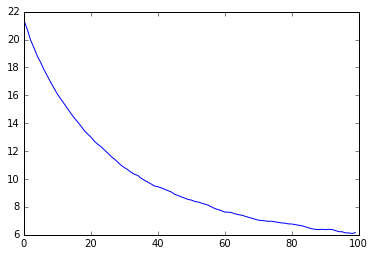

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(loss_values[i:i+5]) for i in range(len(loss_values))])
plt.show()


## Evaluation
Accuracy is depend on the number of epoch that you set in partametrs part.

In [22]:
with tf.variable_scope(tf.get_variable_scope()):
    tf.get_variable_scope().reuse_variables()
    num_iter = int(math.ceil(dataset.test.num_examples / batch_size))
    step = 0
    pred_dict=[]
    while step < num_iter:
        #print step
        x_batch, y_test = dataset.test.next_batch(batch_size)
        image_test = tf.reshape(x_batch, [-1,height,width,1], name = 'image_test') 
        logits_test = inference(image_test)
        pred = tf.cast(logits_test, tf.float32)
        pred_lbl = sess.run(pred)
        pred_dict.append((y_test, pred_lbl))
        step += 1
y_pred = [] # predicted
y_lb = [] # ground truth labels
y_pred_lb = [] # predicted labels
for item in pred_dict:
    for hotcode_val in item[0]:
        y_lb.append(np.argmax(hotcode_val)) # ground truth
    for hotcode_val in item[1]:
        y_pred.append(hotcode_val)
        y_pred_lb.append(np.argmax(hotcode_val)) # ground truth
print "Confusion Matrix:"
print metrics.confusion_matrix(y_true= y_lb, y_pred= y_pred_lb)
print "Precision:"
print metrics.classification_report(y_true= y_lb, y_pred= y_pred_lb)
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true= y_lb, y_pred= y_pred_lb) )
print("Log Loss: %0.6f" % metrics.log_loss(y_true= y_lb, y_pred= y_pred))

Confusion Matrix:
[[185   1   5   0]
 [  0  69 124   0]
 [  0  80 109   0]
 [  0   0   0 195]]
Precision:
             precision    recall  f1-score   support

          0       1.00      0.97      0.98       191
          1       0.46      0.36      0.40       193
          2       0.46      0.58      0.51       189
          3       1.00      1.00      1.00       195

avg / total       0.73      0.73      0.73       768

Classification accuracy: 0.726562
Log Loss: 0.557203


### Benchmark:
- SETI_multi_gpu_train.py achieves ~70% accuracy after 3k epochs of data (45K steps).
- Speed: With batch_size 128.  



|          System              |   Step Time (sec/batch)   |         Accuracy                 |
| ---------------------------- | :-----------------------: |--------------------------------: |
| 4 P100 GPUs w/NVLink np8g4   |       ~0.017              | ~72% at 74K steps  (1.5 hours)   |



## Want to learn more?

[Deep Learning with TensorFlow](http://cocl.us/SETI-NIMBIX-ML0102EN) is a free course in __cognitiveclass.ia__ where you can learn TensorFlow and Deep Learning togetherwe.

Also, running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The PowerAI platform supports popular machine learning libraries and dependencies including Tensorflow, Caffe, Torch, and Theano. You can download a [free version of PowerAI](http://cocl.us/SETI-NIMBIX-PowerAI).

### Authors

<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://ibm.box.com/shared/static/tyd41rlrnmfrrk78jx521eb73fljwvv0.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
#### Saeed Aghabozorgi

[Saeed Aghabozorgi](https://ca.linkedin.com/in/saeedaghabozorgi), PhD is Sr. Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

